EEG wave detection and classification

In [2]:
# import libraries
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [173]:
# load data
file_path = '/Users/DanDan/Downloads/emotions.csv'
df = pd.read_csv(file_path)
df.shape

(2132, 2549)

In [8]:
# basic info
df.isnull().sum()

# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64

In [49]:
# labels counts
df.label.value_counts(normalize = True)

NEUTRAL     0.335835
NEGATIVE    0.332083
POSITIVE    0.332083
Name: label, dtype: float64

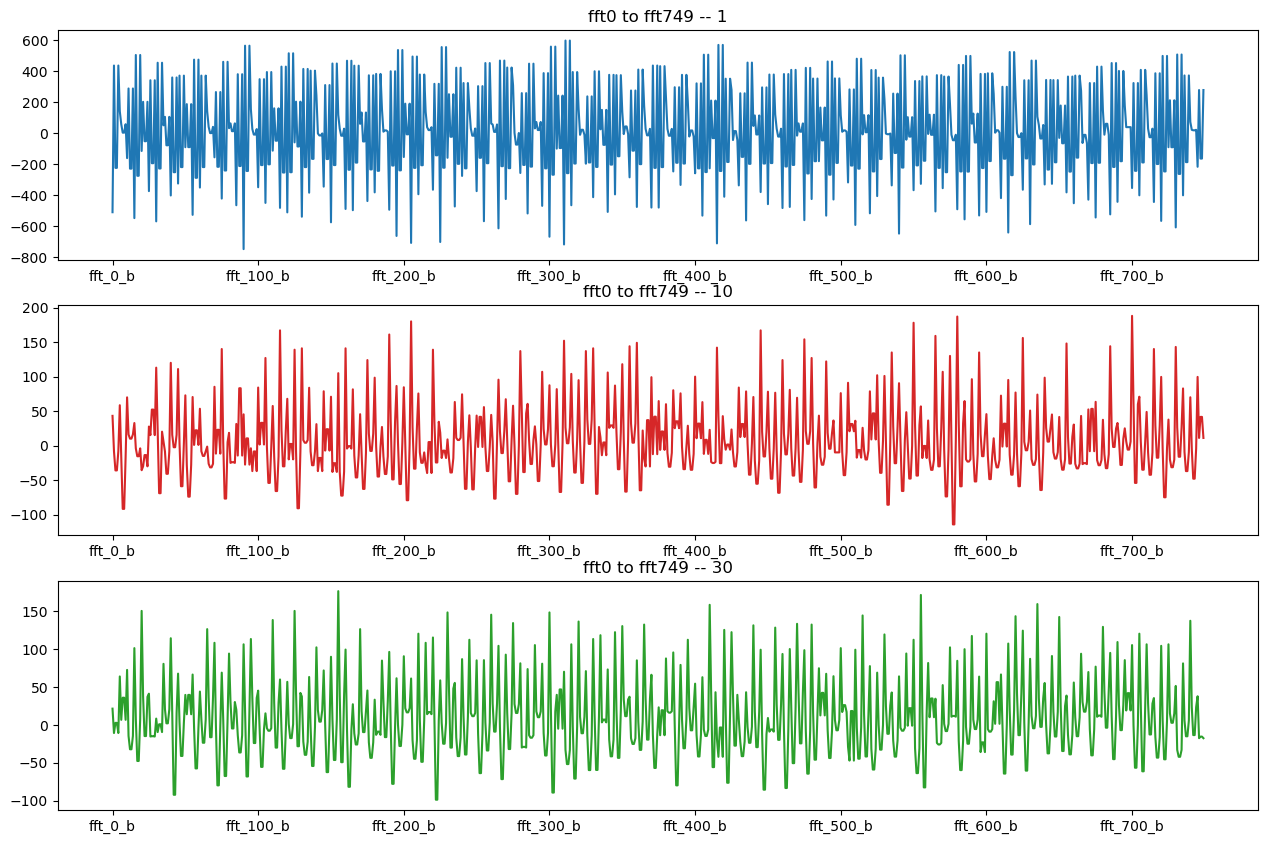

In [89]:
# EEG wave plots
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 10))

df.loc[0, 'fft_0_b': 'fft_749_b'].plot(title = 'fft0 to fft749 -- 1', color = 'tab:blue', ax = axes[0])
df.loc[10, 'fft_0_b':'fft_749_b'].plot(title='fft0 to fft749 -- 10', color='tab:red', ax=axes[1])
df.loc[30, 'fft_0_b':'fft_749_b'].plot(title='fft0 to fft749 -- 30', color='tab:green', ax=axes[2])

plt.subplots_adjust(left = 0.1, bottom= 0.1)

In [174]:
# categorical  -> numeric

labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['label'])

# split train, test dataset
X = df
y = df.pop('label')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [94]:
X_train.shape, X_test.shape

((1705, 2548), (427, 2548))

XGBoost

In [74]:
# hypterparamter optimization
# randomizedSearchCV

model  = XGBClassifier()

model_params = {'objective': ['multi:softprob', 'multi:softmax'],
                 'max_depth': [5, 10],
               'learning_rate': [0.01, 0.05, 0.1],
               'min_child_weight': [1, 10]}

model_rs = RandomizedSearchCV(model,
                            param_distributions = model_params,
                            cv = 3,
                            random_state = 42,
                            n_iter = 10,
                            n_jobs = -1,
                            verbose = 1)

model_rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
               

In [75]:
model_rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [175]:
test_model  = XGBClassifier(colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=10,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto')

In [82]:
y_pred = model_rs.predict(X_test)

In [164]:
accuracy = metrics.accuracy_score(y_test, test_pred)
print(f'XGBoost model accuracy:{accuracy}')

XGBoost model accuracy:0.9976580796252927


In [180]:
confusion_matrix(y_test,test_pred)

array([[143,   0,   0],
       [  0, 148,   0],
       [  1,   0, 135]])

LSTM

In [181]:
# load data
file_path = '/Users/DanDan/Downloads/emotions.csv'
df = pd.read_csv(file_path)
df.shape

(2132, 2549)

In [182]:
# repeart the train, test split
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['label'])

# split train, test dataset
X = df
y = df.pop('label')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [183]:
# reshape the input data

XZ_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
XZ_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

In [184]:
yZ_train = pd.get_dummies(y_train)
yZ_test = pd.get_dummies(y_test)

In [185]:
# set up lstm layers
# simple structure

# input layer, 
i_lstm = Input(shape = (XZ_train.shape[1], 1))

# lstm model
x_lstm = LSTM(256, return_sequences = True)(i_lstm)
x_lstm = Flatten()(x_lstm)

# activation function, softmax multiple classses
y_lstm = Dense(3, activation = 'softmax')(x_lstm)


model_lstm = Model(i_lstm, y_lstm)

model_lstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2548, 1)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 2548, 256)         264192    
                                                                 
 flatten_2 (Flatten)         (None, 652288)            0         
                                                                 
 dense_10 (Dense)            (None, 3)                 1956867   
                                                                 
Total params: 2,221,059
Trainable params: 2,221,059
Non-trainable params: 0
_________________________________________________________________


In [188]:
# compile model

model_lstm.compile(optimizer = 'adam',
                  loss = ['categorical_crossentropy'],
                  metrics = ['accuracy'])

# adding earlystop
earlystop = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 1, patience = 10)

# fit model on training data
history = model_lstm.fit(XZ_train, yZ_train,
                        batch_size = 126,
                        validation_data = (XZ_test, yZ_test),
                        epochs = 20,
                        callbacks = [earlystop])

Epoch 1/20
14/14 [==============================] - 288s 20s/step - loss: 10.0813 - accuracy: 0.7636 - val_loss: 6.4421 - val_accuracy: 0.8150
Epoch 2/20
14/14 [==============================] - 314s 22s/step - loss: 3.5007 - accuracy: 0.8915 - val_loss: 1.8592 - val_accuracy: 0.8806
Epoch 3/20
14/14 [==============================] - 230s 16s/step - loss: 1.3973 - accuracy: 0.9284 - val_loss: 1.0297 - val_accuracy: 0.9180
Epoch 4/20
14/14 [==============================] - 263s 19s/step - loss: 0.4908 - accuracy: 0.9619 - val_loss: 0.6690 - val_accuracy: 0.9555
Epoch 5/20
14/14 [==============================] - 246s 17s/step - loss: 0.0519 - accuracy: 0.9900 - val_loss: 0.2036 - val_accuracy: 0.9859
Epoch 6/20
14/14 [==============================] - 204s 15s/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.4146 - val_accuracy: 0.9696
Epoch 7/20
14/14 [==============================] - 185s 13s/step - loss: 2.6167e-05 - accuracy: 1.0000 - val_loss: 0.1973 - val_accuracy: 0.9859
E

In [189]:
# accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

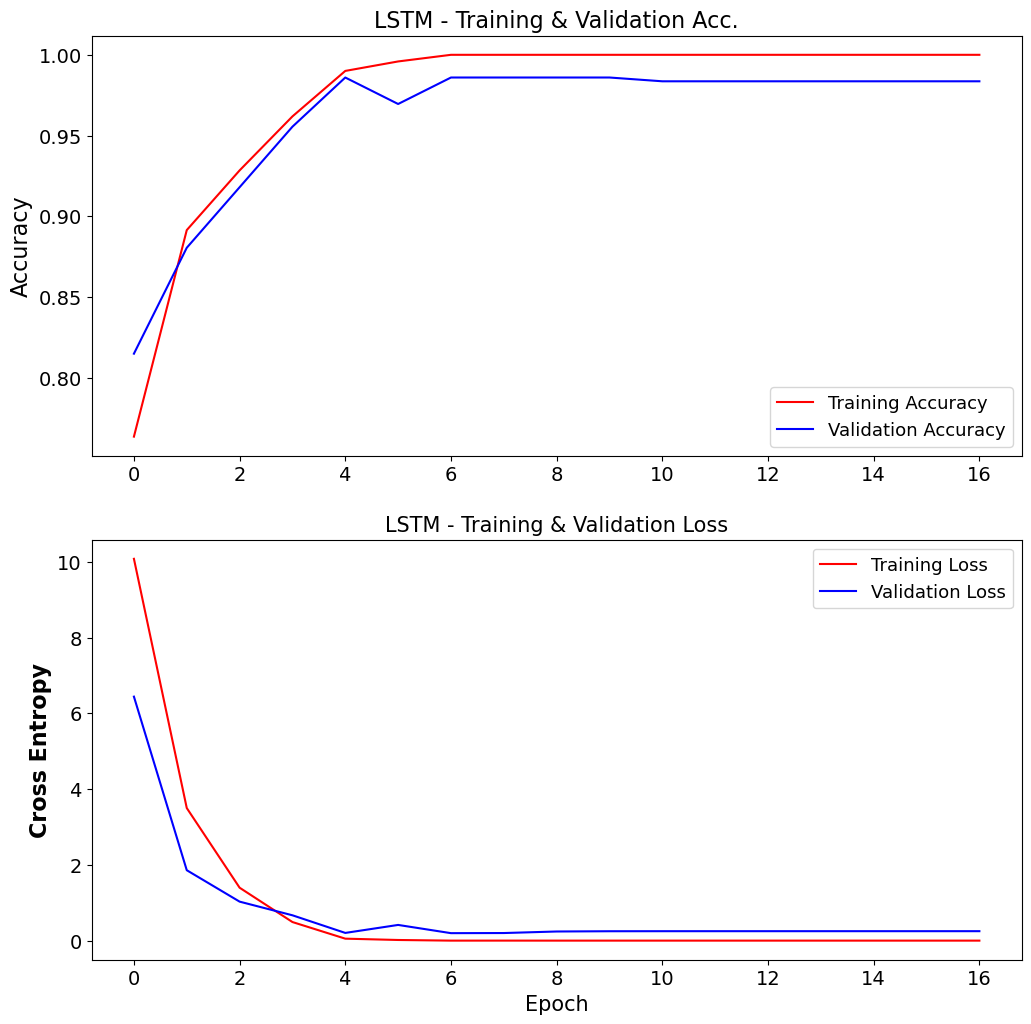

In [190]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16)
plt.title('LSTM - Training & Validation Acc.', fontsize=16)


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)

plt.show()

In [191]:
test_loss = model_lstm.evaluate(XZ_test, yZ_test, verbose=0)[0]
test_accuracy = model_lstm.evaluate(XZ_test, yZ_test, verbose =0)[1]
test_loss, test_accuracy

(0.2496715933084488, 0.9836065769195557)

In [192]:
print(f'LSTM model accuracy: {test_accuracy}')

LSTM model accuracy: 0.9836065769195557


In [194]:
y_pred = model_lstm.predict(XZ_test)

14/14 [==============================] - 26s 2s/step


In [197]:
y_pred = np.argmax(y_pred, axis = 1)

In [198]:
confusion_matrix(y_test,y_pred)

array([[143,   0,   0],
       [  0, 146,   2],
       [  5,   0, 131]])

DNN

In [217]:
# reload data
file_path = '/Users/DanDan/Downloads/emotions.csv'
df = pd.read_csv(file_path)
df.shape

(2132, 2549)

In [218]:
# categorical  -> numeric

labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['label'])

In [219]:
y = df['label']
X = df.drop('label', axis = 1)

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size = 0.2)

In [221]:
# scaling data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [232]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [223]:
# neural network structure 
i_dnn = Input(shape = (2548, ))

x_dnn = Dense(1274, activation = 'relu')(i_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

x_dnn = Dense(2548, activation = 'relu')(i_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

x_dnn = Dense(5096, activation = 'relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

y_dnn = Dense(3, activation = 'softmax')(x_dnn)

dnn_model = Model(i_dnn, y_dnn)
dnn_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2548)]            0         
                                                                 
 dense_16 (Dense)            (None, 2548)              6494852   
                                                                 
 batch_normalization_10 (Bat  (None, 2548)             10192     
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 2548)              0         
                                                                 
 dense_17 (Dense)            (None, 5096)              12989704  
                                                                 
 batch_normalization_11 (Bat  (None, 5096)             20384     
 chNormalization)                                          

In [233]:
dnn_model.compile(optimizer = 'adam',
                  loss = ['categorical_crossentropy'],
                  metrics = ['accuracy'])


earlystop = EarlyStopping(monitor = 'val_loss', mode = 'auto', verbose = 1, patience = 10)

dnn_history = dnn_model.fit(Xs_train, y_train,
                        batch_size = 126,
                        validation_data = (Xs_test, y_test),
                        epochs = 20,
                        callbacks = [earlystop])

Epoch 1/20
14/14 [==============================] - 8s 348ms/step - loss: 1.7809 - accuracy: 0.8323 - val_loss: 6.1482 - val_accuracy: 0.7494
Epoch 2/20
14/14 [==============================] - 5s 321ms/step - loss: 0.5074 - accuracy: 0.9226 - val_loss: 3.9177 - val_accuracy: 0.7681
Epoch 3/20
14/14 [==============================] - 5s 323ms/step - loss: 0.2344 - accuracy: 0.9496 - val_loss: 1.5913 - val_accuracy: 0.8782
Epoch 4/20
14/14 [==============================] - 5s 325ms/step - loss: 0.1015 - accuracy: 0.9683 - val_loss: 0.5424 - val_accuracy: 0.9321
Epoch 5/20
14/14 [==============================] - 5s 334ms/step - loss: 0.0703 - accuracy: 0.9777 - val_loss: 0.5183 - val_accuracy: 0.9368
Epoch 6/20
14/14 [==============================] - 5s 334ms/step - loss: 0.0537 - accuracy: 0.9818 - val_loss: 0.2878 - val_accuracy: 0.9532
Epoch 7/20
14/14 [==============================] - 5s 337ms/step - loss: 0.0612 - accuracy: 0.9801 - val_loss: 0.1472 - val_accuracy: 0.9696
Epoch 

In [208]:
acc = dnn_history.history['accuracy']
val_acc = dnn_history.history['val_accuracy']

loss = dnn_history.history['loss']
val_loss = dnn_history.history['val_loss']

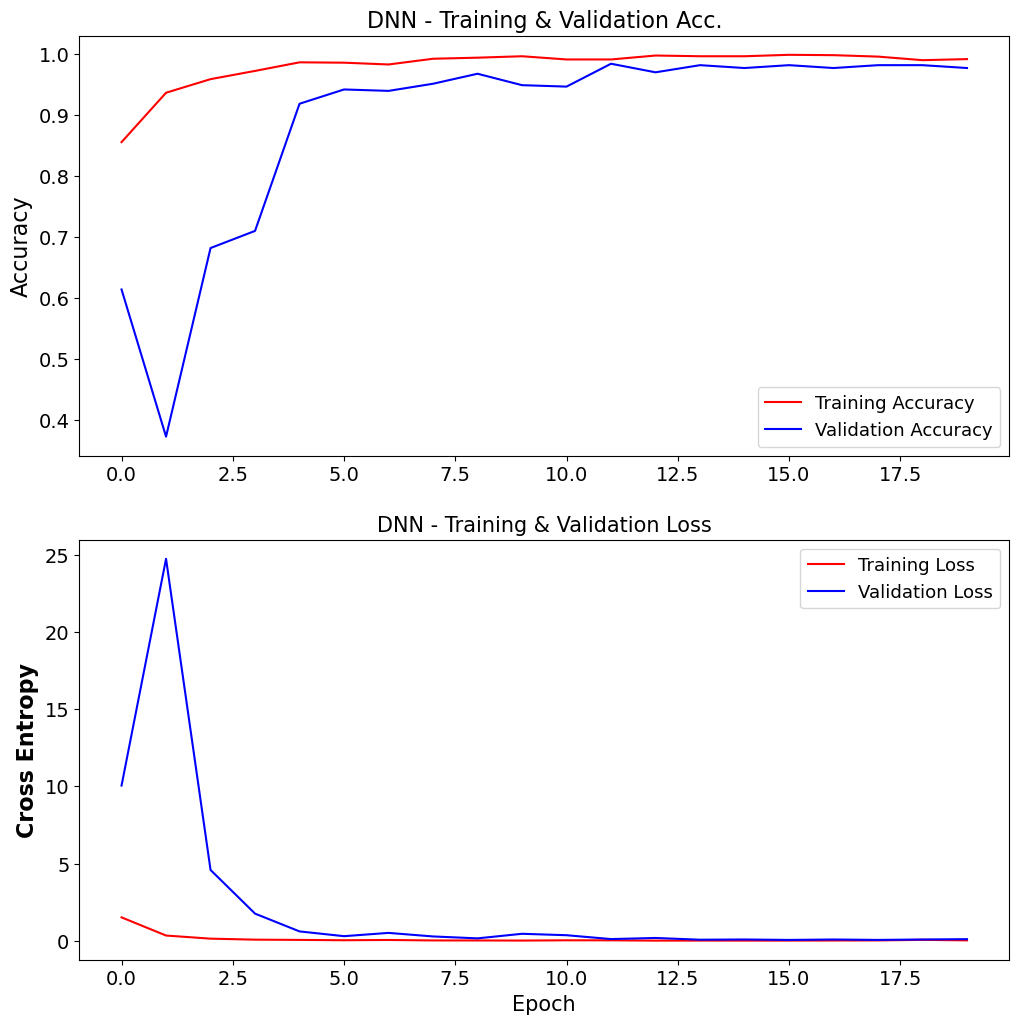

In [209]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16)
plt.title('DNN - Training & Validation Acc.', fontsize=16)


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('DNN - Training & Validation Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)

plt.show()

In [210]:
test_loss = dnn_model.evaluate(Xs_test, y_test, verbose=0)[0]
test_accuracy = dnn_model.evaluate(Xs_test, y_test, verbose =0)[1]
test_loss, test_accuracy

(0.10321126878261566, 0.976580798625946)

In [212]:
y_pred = dnn_model.predict(Xs_test)

14/14 [==============================] - 1s 37ms/step


In [229]:
y_pred = np.argmax(y_pred, axis = 1)

In [230]:
confusion_matrix(y_test,y_pred)

array([[142,   0,   1],
       [  0, 145,   3],
       [  6,   0, 130]])

Conlucsions

In [ ]:
# 1. XGboost model accuracy: 0.9976580796252927
# 2. LSTM model accuracy  : 0.9836065769195557
# 3. DNN model accuracy : 0.976580798625946

# XGBoost model generates the highest accuracy, gradient boosting work good on medium size data (not null values)
# The accuracy of DNN is smaller, which is challenging task to build own neural network layers, the # of layers is 
# unknown, the node(neuron) size is unclear, so the parmaters are not ideal. 

# To solve this problem, there are two ways:
# a. find out the optimal numbers of layers, activation functions, dropout rate, learning rate, etc
# b. Seems there is overfitting issue in DNN, in the next step, resample the whole dataset could reduce the effect. 
# Adding regularization


# 4.In this project, we use three models to conduct the EEG data analysis. We could get better results if implement 
# above methods. 